# Pricing of fixed income assets

Assuming an uncertain distribution of interest rates for different run times...

Given a cashflow $c_t$, for time periods $t=1,...,T$ (face values, coupon payments, ...)
[need to derive consistent interest rates for e.g. 1.5 years for coupons] ?

TBD


Net present value of cashflow is given by...

In [1]:
from qiskit_aqua.algorithms.components.uncertainty_models.multivariate_normal_distribution import MultivariateNormalDistribution
from qiskit_aqua.algorithms.components.uncertainty_problems.fixed_income_expected_value import FixedIncomeExpVal
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import numpy as np
from qiskit_aqua.algorithms.single_sample import AmplitudeEstimation

In [2]:
# derive uncertainty model for the interest rates using real data
A = np.eye(2)
b = np.zeros(2)

# specify the lower and upper bounds for the different dimension
low = [-0.25, -0.1]
high = [0.5, 0.1]
mu = np.zeros(2)
sigma = np.eye(2)

# specify the number of qubits that are used to represent the different dimenions of the uncertainty model
num_qubits = [2, 2]

# construct corresponding distribution
u = MultivariateNormalDistribution(num_qubits, low, high, mu, sigma)

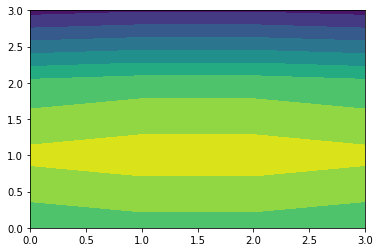

In [3]:
plt.contourf(u.probabilities.reshape(2**num_qubits[0], 2**num_qubits[1]))
plt.show()

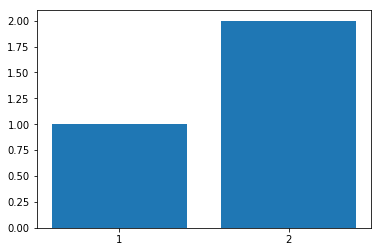

In [4]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf)+1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods)
plt.show()

In [5]:
# estimate real value
cnt = 0
exact_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            exact_value += prob * (cf[t]/pow(1 + b[t], t+1) - (t+1)*cf[t]*np.dot(A[:, t], np.asarray([x1, x2]))/pow(1 + b[t], t+2))
        cnt += 1

In [6]:
# specify approximation factor
c_approx = 0.05

# get fixed income circuit factory
fixed_income = FixedIncomeExpVal(u, A, b, cf, c_approx)

In [7]:
# evaluate via sampling
q = QuantumRegister(fixed_income.num_target_qubits)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
fixed_income.build(qc, q, params={'i_state': range(u.num_target_qubits), 'i_objective': u.num_target_qubits})

qc.measure(q[u.num_target_qubits], c[0])

shots = 1000
job = execute(qc, backend=Aer.get_backend('qasm_simulator_py'), config={'shots': shots})
result = job.result()
value = result.get_counts()['1']/shots
print('value:     ', value)
print('estimator: ', np.round(fixed_income.value_to_estimator(value), decimals=4))
print('exact value:', np.round(exact_value, decimals=4))

value:      0.005
estimator:  2.8828
exact value: 2.8845


In [13]:
# set number of evaluation qubits (samples)
m = 2

# construct amplitude estimation 
ae = AmplitudeEstimation(m, fixed_income)

In [14]:
# result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator_py'), shots=100)
result = ae.run(quantum_instance=Aer.get_backend('statevector_simulator_py'))

In [15]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimator'])
print('Probability:    \t%.4f' % result['max_prob'])

Exact value:    	2.8845
Estimated value:	2.8750
Probability:    	0.9916


In [16]:
result

{'a_items': [(0.0, 0.99157704336814001),
  (0.50000000000000011, 0.006745197650985451),
  (1.0, 0.001677758980936373)],
 'estimator': 2.875,
 'mapped_items': [(2.875, 0.99157704336814001),
  (3.6499999999999999, 0.006745197650985451),
  (4.4249999999999998, 0.001677758980936373)],
 'mapped_values': [2.875, 3.6499999999999999, 4.4249999999999998],
 'max_prob': 0.99157704336814001,
 'probabilities': [0.99157704336814001,
  0.006745197650985451,
  0.001677758980936373],
 'statevector': array([[ 0.24655024 -2.30000000e-15j,  0.00168292 +3.00000000e-16j,
          0.00126790 -2.10364453e-03j, ...,  0.00000000 -0.00000000e+00j,
         -0.00000000 -0.00000000e+00j,  0.00000000 -0.00000000e+00j]]),
 'values': [0.0, 0.50000000000000011, 1.0],
 'y_items': [(0, 0.99157704336814001),
  (1, 0.0033725988254927008),
  (2, 0.001677758980936373),
  (3, 0.0033725988254927506)],
 'y_values': [0, 1, 2, 3]}

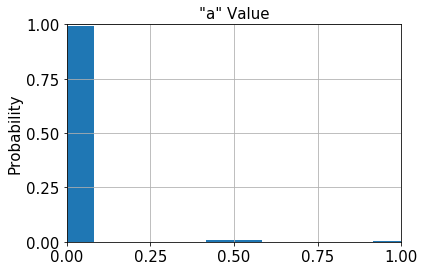

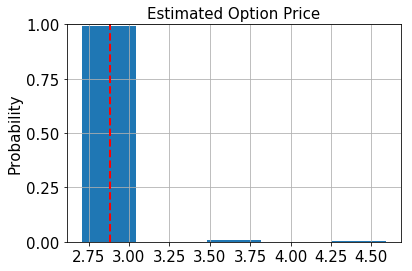

In [17]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price
plt.bar(result['mapped_values'], result['probabilities'], width=1/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()